# Personalized Code Auto-Completion Model

In [ ]:
# Check whether GPU is available
import torch
torch.cuda.is_available()

True

In [ ]:
# Check how much memory is available
!nvidia-smi 

Wed Aug 26 17:25:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check how much storage is left on disk
!df -h 

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   31G   35G  48% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   16K  6.4G   1% /var/colab
/dev/sda1        75G   32G   43G  43% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


# Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from torch import nn
from sklearn.model_selection import train_test_split

# Data preprocessing

### Data ingestion

In [ ]:
# Data loading
with open('autocomplete.txt', 'r') as f:
    data = f.read()

# A tuple of distinct characters
chars = list(set(data))
print(chars)

['D', 'I', '_', '@', '`', 'c', 'N', 'R', 'V', 'k', 'q', '}', 'z', ',', 'B', '7', '6', '.', 'j', '$', '(', '/', 'F', '[', ':', 'G', 'x', '{', 'l', 'Y', 'b', 't', '+', '%', '>', '1', 'O', '*', '~', 'P', 'd', '0', '&', '\t', 'E', '^', '=', 'f', 'S', 'h', 'p', '\\', 'm', '?', 'H', '!', 'T', '\n', '|', 'U', 'M', 'J', 'n', 'e', 'i', '8', '5', 'w', ';', 'Z', ')', 'L', 'v', 'r', 'K', 'a', '<', 'y', ' ', 'W', 'A', '3', '9', '-', 'Q', 'g', 'X', 's', 'o', '2', '"', 'C', ']', '4', 'u', "'"]


### Data encoder

In [ ]:
# Hash tables for encoding
# int2char: integer -> character
# char2int: character -> integer

int2char = dict(enumerate(chars))
print(int2char)
char2int = dict(map(reversed, int2char.items()))
print(char2int)

{0: 'D', 1: 'I', 2: '_', 3: '@', 4: '`', 5: 'c', 6: 'N', 7: 'R', 8: 'V', 9: 'k', 10: 'q', 11: '}', 12: 'z', 13: ',', 14: 'B', 15: '7', 16: '6', 17: '.', 18: 'j', 19: '$', 20: '(', 21: '/', 22: 'F', 23: '[', 24: ':', 25: 'G', 26: 'x', 27: '{', 28: 'l', 29: 'Y', 30: 'b', 31: 't', 32: '+', 33: '%', 34: '>', 35: '1', 36: 'O', 37: '*', 38: '~', 39: 'P', 40: 'd', 41: '0', 42: '&', 43: '\t', 44: 'E', 45: '^', 46: '=', 47: 'f', 48: 'S', 49: 'h', 50: 'p', 51: '\\', 52: 'm', 53: '?', 54: 'H', 55: '!', 56: 'T', 57: '\n', 58: '|', 59: 'U', 60: 'M', 61: 'J', 62: 'n', 63: 'e', 64: 'i', 65: '8', 66: '5', 67: 'w', 68: ';', 69: 'Z', 70: ')', 71: 'L', 72: 'v', 73: 'r', 74: 'K', 75: 'a', 76: '<', 77: 'y', 78: ' ', 79: 'W', 80: 'A', 81: '3', 82: '9', 83: '-', 84: 'Q', 85: 'g', 86: 'X', 87: 's', 88: 'o', 89: '2', 90: '"', 91: 'C', 92: ']', 93: '4', 94: 'u', 95: "'"}
{'D': 0, 'I': 1, '_': 2, '@': 3, '`': 4, 'c': 5, 'N': 6, 'R': 7, 'V': 8, 'k': 9, 'q': 10, '}': 11, 'z': 12, ',': 13, 'B': 14, '7': 15, '6': 16

### Data loader

In [ ]:
# Load data batch by batch
def data_loader(data, num_seqs, seq_length):
    data = np.array(list(data))
    batch_size = num_seqs * seq_length
    num_batches = len(data) // batch_size
    data = data[:num_batches * batch_size]
    data = data.reshape((num_seqs, -1))
    
    for n in range(0, data.shape[1] - seq_length, seq_length):
        input_seqs = data[:, n:n + seq_length]
        labels = np.zeros_like(input_seqs)
        labels[:, :-1], labels[:, -1] = input_seqs[:, 1:], data[:, n + seq_length]
        yield input_seqs, labels

# Model architecture

### Model hyperparameters

In [ ]:
# Initialize the model hyperparameters
num_epochs=10
num_seqs=1024 # 1024 samples in one batch
seq_length=6 # input sequences have 6 chars
num_chars = len(chars) # number of distinct characters

lr=0.001 # learning rate
device = torch.device("cuda:0") # Use GPU

### Helper functions


In [ ]:
# Convert integer into one hot encoding
# 0 -> [1, 0, 0 ...]
# 1 -> [0, 1, 0 ...]
def one_hot_encoding(input_seqs, num_chars):
    
    one_hot = np.zeros((input_seqs.shape[0] * input_seqs.shape[1], num_chars), dtype=np.float32)

    # Fill in ones corresponding to the index
    one_hot[np.arange(input_seqs.shape[0] * input_seqs.shape[1]), input_seqs.ravel()] = 1

    # Reshape it to (num_seqs, sequence_length, num_chars)
    one_hot = one_hot.reshape((input_seqs.shape[0], input_seqs.shape[1], num_chars))

    return one_hot

# save the model parameters and hyparameters into a file
def save_checkpoint(net, optimizer, filename, train_history={}):
    checkpoint = {'n_hidden': net.n_hidden,
                  'n_layers': net.n_layers,
                  'state_dict': net.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'tokens': net.chars,
                  'train_history': train_history}

    with open(filename, 'wb') as f:
        torch.save(checkpoint, f)

# load the model parameters and hyparameters from a file
def load_checkpoint(filename):
    with open(filename, 'rb') as f:
        checkpoint = torch.load(f, map_location='cpu')

    net = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
    net.load_state_dict(checkpoint['state_dict'])

    return net

In [ ]:
# Testing one_hot_encoding is correct or not
one_hot = one_hot_encoding(np.array([[0, 1, 2],[0, 1, 2]]), 3)
print(one_hot)

[[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]


### Architecture

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, tokens, n_hidden=256, n_layers=3, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.chars = tokens

        self.lstm = nn.LSTM(num_chars, n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, num_chars)

    def forward(self, input_seqs, hidden):
        # pass through lstm
        all_outputs, hidden = self.lstm(input_seqs, hidden)

        # pass through dropout
        all_outputs = self.dropout(all_outputs)

        # pass through fc layer
        all_outputs = self.fc(all_outputs)

        # return the cell_state and hidden tensor
        return all_outputs, hidden

# Model training

### Tokenization

In [ ]:
# Translate character to integer
data = np.array([char2int[x] for x in data])
data

array([47, 73, 88, ..., 36, 22, 57])

### Training testing split

In [ ]:
# Split training and validation data, 9:1
train_len = math.floor(data.size * 0.9)
print(data.size)
print(train_len)
val_data = data[train_len:]
print(val_data)
print(val_data.size)
data = data[:train_len]
print(data)
print(data.size)

21702253
19532027
[78 57 78 ... 36 22 57]
2170226
[47 73 88 ... 78 78 78]
19532027


### Training pipeline

In [ ]:
# Initialize the model
net = CharRNN(chars, n_hidden=256, n_layers=3)
net.train() # Training mode
net.to(device) # Use GPU

# Loss and optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
loss_function = torch.nn.CrossEntropyLoss()

# Train the model
train_history = {'epoch': [], 'step': [], 'loss': [], 'val_loss': []}
for epoch in range(num_epochs):
    hidden = None
    
    for input_seqs, labels in data_loader(data, num_seqs, seq_length):
        # Data transformation
        input_seqs = one_hot_encoding(input_seqs, num_chars)
        input_seqs = torch.from_numpy(input_seqs).to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        
        # Forward pass
        
        # set all the gradient variables zero
        optimizer.zero_grad()

        # call model forward and get the outputs
        all_outputs, hidden = net.forward(input_seqs, hidden)
        
        # compute the loss
        loss = loss_function(all_outputs.view(num_seqs * seq_length, num_chars), labels.view(num_seqs * seq_length))
        
        # Backward pass

        # compute the gradient
        loss.backward()

        # gradient clipping, gradient has norm at most 6
        nn.utils.clip_grad_norm_(net.parameters(), 6)
        
        # update the weights
        optimizer.step()
        
        # Detach hidden state and cell state from the graph
        hidden = (hidden[0].detach(), hidden[1].detach())
    
    # validation
    with torch.no_grad():
        val_hidden = None
        val_loss_lst = []
        
        for input_seqs, labels in data_loader(val_data, num_seqs, seq_length):

            # Data transformation
            input_seqs = one_hot_encoding(input_seqs, num_chars)
            input_seqs = torch.from_numpy(input_seqs).to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            # Forward pass
            all_outputs, val_hidden = net.forward(input_seqs, hidden)
            
            # Compute loss
            val_loss = loss_function(all_outputs.view(num_seqs * seq_length, num_chars), labels.view(num_seqs * seq_length))
            val_loss_lst.append(val_loss.item())
        
        # Compute average validation loss
        mean_val_loss = np.mean(val_loss_lst)
        print('Epoch ', epoch, ': validation loss ', mean_val_loss)
        
        # track progress
        train_history['epoch'].append(epoch+1)
        train_history['loss'].append(loss.item())
        train_history['val_loss'].append(mean_val_loss)
    
    # save model checkpoint if we get better performance
    min_val_loss = 100
    if mean_val_loss < min_val_loss:
        save_checkpoint(net, optimizer, 'autocomplete.net', train_history=train_history)
        min_val_loss = mean_val_loss

Epoch  0 : validation loss  2.560737742619081
Epoch  1 : validation loss  2.665734747594053
Epoch  2 : validation loss  2.7151898714629086
Epoch  3 : validation loss  2.7258578207005155
Epoch  4 : validation loss  2.8032911365682427
Epoch  5 : validation loss  2.8305734280835497
Epoch  6 : validation loss  2.863573606041345
Epoch  7 : validation loss  2.9030685878612776
Epoch  8 : validation loss  2.8759359365159813
Epoch  9 : validation loss  2.9874897904016753


Text(0.5, 1.0, 'Train and validation loss')

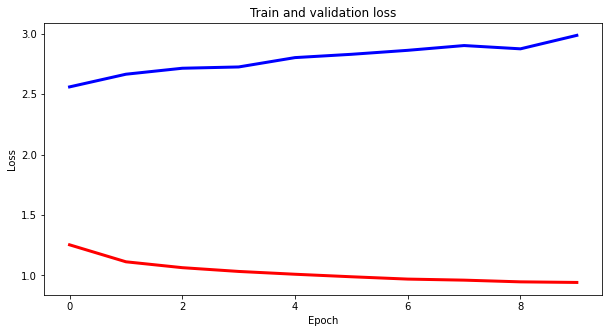

In [ ]:
# Visualize loss
plt.figure(figsize=(10, 5))
plt.plot(train_history['loss'], lw=3, c='red')
plt.plot(train_history['val_loss'], lw=3, c='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train and validation loss")

# Model testing

### Helper function

In [ ]:
def prediction(net, input_seqs='import'):
    net.to(device)
    net.eval()

    chars = []
    hidden = None
    for input_seq in input_seqs:
        with torch.no_grad():
            input_seq = np.array([[char2int[input_seq]]])
            input_seq = one_hot_encoding(input_seq, len(net.chars))
            input_seq = torch.from_numpy(input_seq).to(device)
            out, hidden = net.forward(input_seq, hidden)
            
            probs = torch.nn.functional.softmax(out, dim=2).data.to('cpu')
            char = int2char[int(torch.argmax(probs))]
        chars.append(char)
        
        if char == '\n': break
            
    return ''.join(chars)

### Testing cases

In [ ]:
# load the trained model from checkpoint
net = load_checkpoint('autocomplete.net')

In [ ]:
# Test case 1
input_seqs = 'from torc'
print(input_seqs + prediction(net, input_seqs=input_seqs))

from torch.nn.functional as F



In [ ]:
# Test case 2
input_seqs = 'import matpl'
print(input_seqs + prediction(net, input_seqs=input_seqs))

import matplotlib.pyplot as plt

